---
# Simulate pRF-experiment

In [278]:
%reload_ext autoreload
%autoreload 2

In [50]:

import numpy as np
import pandas as pd
import nideconv as nd
from nideconv import simulate
import nibabel as nb
from prfpy import *
from prfpy.stimulus import PRFStimulus2D
from prfpy.model import Iso2DGaussianModel,Norm_Iso2DGaussianModel
from prfpy.fit import Iso2DGaussianFitter,Norm_Iso2DGaussianFitter
from linescanning import *
from linescanning import glm,image,prf
import scipy as sp
from scipy.io import loadmat
import matplotlib.pyplot as plt
import warnings
import matplotlib.patches as patches
import seaborn as sns
import os
import yaml

opj = os.path.join
base, place = utils.get_base_dir()

base_dir = opj(base, 'projects', 'hemifield')
fig_dir = opj(base_dir, 'code', 'figures')

# ignore warnings
warnings.simplefilter("ignore")

/data1/projects/MicroFunc/Jurjen/projects/hemifield/derivatives/prf/sub-003/vis_design.mat
Shape dm = (500, 500, 120)
[0.7416407864998732, -2.282535639108368, 0.4388850415512466, 1.2100668755010702e-05, -0.21565771102905276, 0.7366697788238525]


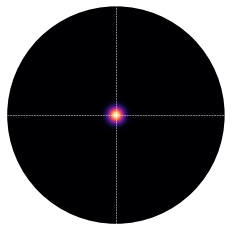

In [114]:
sub = 'sub-003'

design_fn = utils.get_file_from_substring("vis_design.mat", opj(base_dir, 'derivatives', 'prf', sub))
params_fn = utils.get_file_from_substring("best_vertices", opj(base_dir, 'derivatives', 'pycortex', sub))
wb_data_fn = utils.get_file_from_substring("desc-avg_bold_hemi-L.npy", opj(base_dir, 'derivatives', 'prf', sub))
wb_data = np.load(wb_data_fn)
print(design_fn)

if os.path.exists(design_fn):
    design_matrix = loadmat(design_fn)
    print(f"Shape dm = {design_matrix['stim'].shape}")
else:
    raise ValueError(f"Could not find {design_fn}")

if os.path.exists(params_fn):
    params_df = utils.VertexInfo(params_fn)
    params = params_df.get('prf', hemi='L')
else:
    params = np.array([2.283,-0.742,1.039,0.189,-0.163,0.01,18.,0.189,1.,0.745])

print(params)
vf_extent = [-5, 5]
prf_stim = stimulus.PRFStimulus2D(screen_size_cm=70, screen_distance_cm=225, design_matrix=design_matrix['stim'],TR=1.5)

prf_array = prf.make_prf(prf_stim, size=params[2])
prf.plot_prf(prf_array, vf_extent)

# starting stimulus design
design_matrix = loadmat(opj(base_dir, 'derivatives', 'prf', sub, 'vis_design.mat'))

# define model
gg = model.Iso2DGaussianModel(stimulus=prf_stim,
                                   filter_predictions=False,
                                   filter_type='sg',
                                   filter_params={'window_length': 300, 'polyorder': 1})


In [115]:
wb_data.shape

(120, 362360)

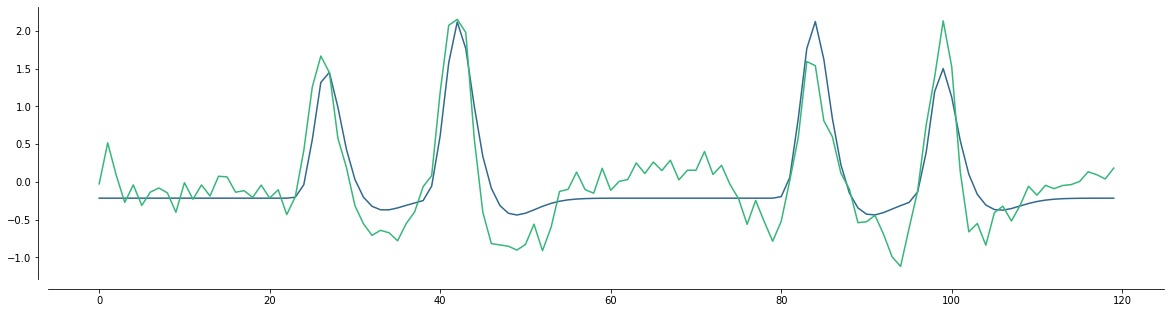

In [117]:
x = np.squeeze(gg.return_prediction(*params).T)
vert_data = wb_data[:,params_df.get('index', hemi='L')]
glm.plot_array([x,vert_data], xkcd=False, save_as=opj(fig_dir, 'sub-003_prediction.svg'), figsize=(20,5))

In [118]:
# Define parameters
# new_params = np.array([2.283, -0.742, 1.039,  0.175, -0.17, 0.01, 12, 0.175,  1, 0.909])
gg_norm = model.Norm_Iso2DGaussianModel(stimulus=prf_stim,
                                        filter_predictions=False,
                                        filter_type='sg',
                                        filter_params={'window_length': 300, 'polyorder': 1})
                                   
gf_norm = fit.Norm_Iso2DGaussianFitter(gg_norm, vert_data[...,np.newaxis].T)

In [119]:
# gridfit
surround_amplitude_grid = np.array([0.01, 0.1, 1, 10], dtype='float32')
surround_size_grid=np.array([5,8,12,18], dtype='float32')
neural_baseline_grid=np.array([0,1,10,100], dtype='float32')
surround_baseline_grid=np.array([0.1,1.0,10.0,100.0], dtype='float32')

#################################################################################################################
# # Uncomment to rerun gridsearch
# # ~250s
old_params = np.array((*params[:3], params[-1]))[np.newaxis,...]
gf_norm.grid_fit(surround_amplitude_grid, 
                 surround_size_grid, 
                 neural_baseline_grid,
                 surround_baseline_grid, 
                 gaussian_params=old_params,
                 verbose=True,
                 n_batches=1)

new_params = gf_norm.gridsearch_params[0]
#################################################################################################################

Each batch contains approx. 1 voxels.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.1s finished


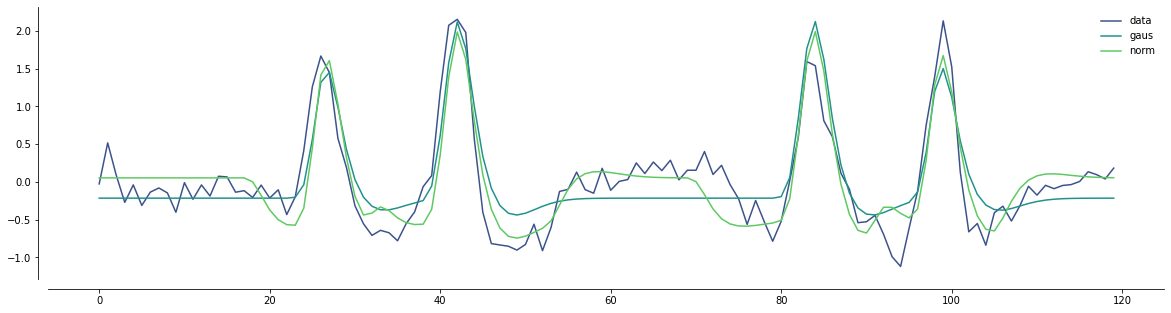

In [122]:
x_norm = np.squeeze(gg_norm.return_prediction(*new_params).T)
vert_data = wb_data[:,params_df.get('index', hemi='L')]
glm.plot_array([vert_data,x,x_norm], labels=["data", "gaus", "norm"], xkcd=False, figsize=(20,5))

In [125]:
print(f"params = {new_params}")
X_prf = new_params[0]
Y_prf = new_params[1]
A = new_params[3]
B = new_params[-3]/new_params[3]
C = new_params[5]
D = new_params[-2]
ss = new_params[6]
r2 = new_params[-1]
prf_size = new_params[2]
norm = ss/A

print(f'X                       = {round(X_prf,2)}')
print(f'Y                       = {round(Y_prf,2)}')
print(f'A (prf amplitude/beta)  = {round(A,2)}')
print(f'B (neural baseline)     = {round(B,2)}')
print(f'C (surround amplitude)  = {round(C,2)}')
print(f'D (surround baseline)   = {round(D,2)}')
print(f'R2                      = {round(r2,2)}')
print(f'Surround size           = {ss}')
print(f'pRF size                = {round(prf_size,2)}')
print(f'Size ratio (phi)        = {round(ss/A,2)}')

params = [  0.742  -2.283   0.439   0.56    0.053   0.01    5.     55.982 100.
   0.794]
X                       = 0.74
Y                       = -2.28
A (prf amplitude/beta)  = 0.56
B (neural baseline)     = 100.0
C (surround amplitude)  = 0.01
D (surround baseline)   = 100.0
R2                      = 0.79
Surround size           = 5.0
pRF size                = 0.44
Size ratio (phi)        = 8.93


Center of pRF = [250, 250]


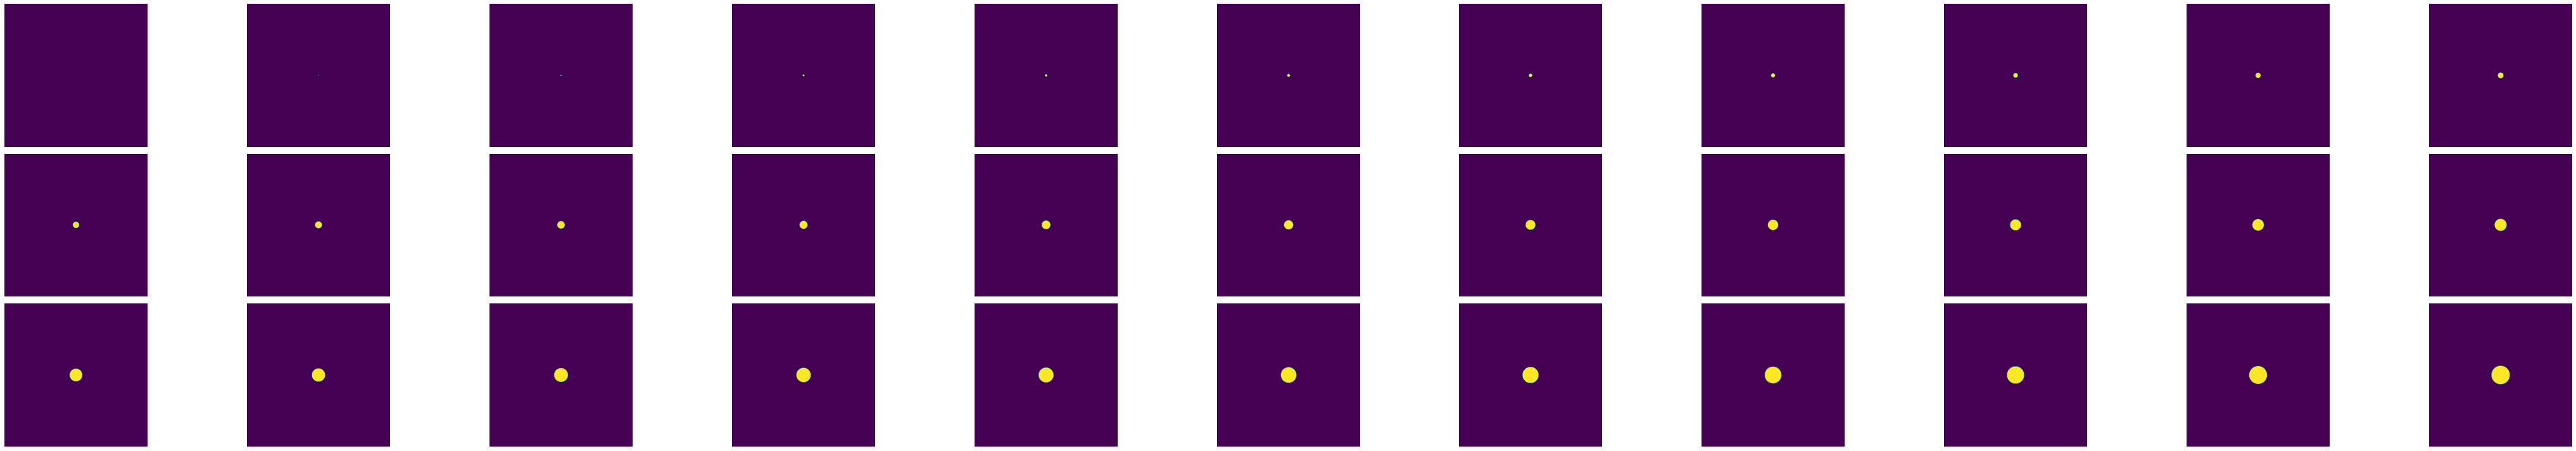

In [126]:
dim_stim = 2
n_pix = prf_stim.design_matrix.shape[0]

center = np.flip(np.squeeze(np.array(np.where(prf == np.amax(prf))[1:])))
center = [n_pix//2,n_pix//2]
print(f"Center of pRF = {center}")

ss_deg = 3.0 * np.degrees(np.arctan(prf_stim.screen_size_cm /(2.0*prf_stim.screen_distance_cm)))

x = np.linspace(-ss_deg/2, ss_deg/2, n_pix)
dx = prf_stim.design_matrix.shape[0]/len(x)

# create filled stimuli
stims_fill, stims_fill_sizes = prf.make_stims(n_pix, prf_stim, factr=4)
prf.plot_stims(stims_fill)

In [127]:
len(stims_fill_sizes)

62

In [218]:
n_pix

270

Making size response curve
3 56
Creating design with 10 stimuli and length of 5700
 Using 0 stimuli of 'hori'-orientation
 Using 0 stimuli of 'vert'-orientation
 Using 0 stimuli of 'rot_45'-orientation
 Using 0 stimuli of 'rot_135'-orientation
 Using 10 stimuli of 'filled'-orientation
 Using 0 stimuli of 'conc'-orientation
Stimuli have shape (500, 500, 70)
ITIs created with total ITI duration of 421.5010897596173 after 1 iterations
New nr of frames = 4014 based on ITIs
Design has shape: (500, 500, 4065)
Creating onset dataframe
Done
Create stimulus vectors
Amplitude for event '0.21' = 0.09
Amplitude for event '0.78' = 0.7
Amplitude for event '1.43' = 1.0
Amplitude for event '2.07' = 0.88
Amplitude for event '2.71' = 0.7
Amplitude for event '3.35' = 0.53
Amplitude for event '3.99' = 0.37
Define HRF
Convolve stimulus vectors with HRF
Downsample stimulus vectors
Add some noise to stimulus vectors


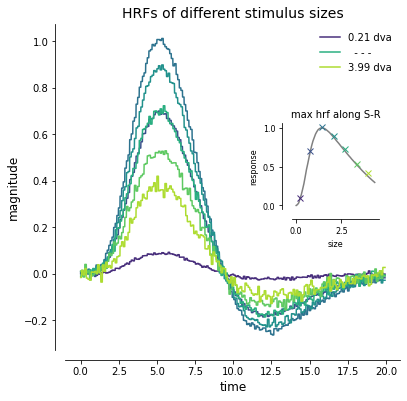

In [221]:
# make size-response curve
print("Making size response curve")
mean_srf_fill = prf.norm_2d_sr_function(A, B, C, D, prf_size, ss, x, x, stims_fill, mu_x=0, mu_y=0)
mean_srf_fill /= mean_srf_fill.max()

# select range of degree-of-visual-angle
lower_dva, upper_dva = utils.find_nearest(stims_fill_sizes,0.2)[0],utils.find_nearest(stims_fill_sizes,4)[0]

n_stims_select = 7

print(lower_dva,upper_dva)
idc_list = list(np.linspace(lower_dva,upper_dva,num=n_stims_select).astype(int))
idc_list

# Half center/half surround
use_settings = {'hori': [0, 18],
                'vert': [0, 14],
                'rot_45': [0, 18],
                'rot_135': [0, 5],
                'filled': [10, idc_list],
                'conc': [0, 0]}

settings_fn = opj(os.path.dirname(glm.__file__), 'experiments', 'gouws', 'settings.yml')
lib2 = prf.create_stim_library(500, prf_stim)
size_response,onset_df = prf.select_stims(use_settings, lib2, verbose=True, frames=5700, return_onsets=True, TR=0.105, settings_fn=settings_fn)

# convert index in stims_fill_sizes to degree-of-visual-angle (dva)
onset_df['event_type'] = [round(stims_fill_sizes[ii],2) for ii in onset_df['event_type'].values]

# sort dvas so we assign correct magnitude to convolution
dva_conds = onset_df['event_type'].unique()
dva_conds.sort()

# set oversampling factor
osf = 1000

# get value in S-R curve per dva
print("Create stimulus vectors")
ampl = mean_srf_fill[idc_list]
stims_v = glm.make_stimulus_vector(onset_df, scan_length=size_response.shape[-1], osf=osf, type='event', amplitude=ampl)

# define HRF
print("Define HRF")
dt = 1/osf
time_points = np.linspace(0,25,np.rint(float(25)/dt).astype(int))
canonical_hrf = glm.double_gamma(time_points, lag=6)

# convolve with HRF
print("Convolve stimulus vectors with HRF")
convolved_v = {}
for ii in dva_conds:
    convolved_v[ii] = glm.convolve_hrf(canonical_hrf, stims_v[ii], make_figure=False)

# downsample to original scale
print("Downsample stimulus vectors")
desired_scale = np.arange(0, int(size_response.shape[-1]), 1)

convolved_v_ds = {}
for ii in dva_conds:
    convolved_v_ds[ii] = glm.resample_stim_vector(convolved_v[ii], size_response.shape[-1])

# add some noise
print("Add some noise to stimulus vectors")
synth_fmri = {}
noise_lvl = np.linspace(0.01,0.05,num=n_stims_select)
for ix,ii in enumerate(dva_conds):
    noise = np.random.normal(0, noise_lvl[ix], size_response.shape[-1])
    synth_fmri[ii] = (convolved_v_ds[ii]+noise).astype(float)

# format the dataframe
TR = 0.105
data = pd.DataFrame(synth_fmri)
data['subject'], data['run'], data['t'] = 1, 1, list(TR*np.arange(data.shape[0]))
data = data.set_index(['subject', 'run', 't'])
data.head()

# format onset times
onset_df['subject'], onset_df['run'] = 1,1
onset_df['event_type'] = onset_df['event_type'].astype(str)
onset_df['onset'] = onset_df['onset'].astype(float)
onset_df2 = onset_df.set_index(['subject', 'run', 'event_type'])
onset_df2

# do the fitting
min_int = 0
max_int = 20
n_regres = None
fs = 1/TR

g_model = nd.GroupResponseFitter(data,
                                 onset_df2,
                                 input_sample_rate=fs,
                                 concatenate_runs=False,
                                 confounds=None, 
                                 add_intercept=False)

cond = onset_df2.reset_index().event_type.unique()
[g_model.add_event(i,
                  basis_set='fir',
                  n_regressors=n_regres,
                  interval=[min_int,max_int]) for i in cond]
           
g_model.fit()

# plot results
cols = sns.color_palette('viridis', dva_conds.shape[0])
tmp = g_model.get_subjectwise_timecourses().reset_index()

fig,axs = plt.subplots(figsize=(6,6))
max_vals = []
for idc,ii in enumerate(dva_conds):

    jj = tmp[(tmp['event type'] == str(ii))][ii].values
    xx = tmp[(tmp['event type'] == str(ii))]['time'].values

    axs.plot(xx,jj, color=cols[idc], label=f"{str(ii)} dva")
    sns.despine(offset=10)
    max_vals.append(np.amax(jj))
    
max_vals = np.array(max_vals)
    
plt.xlabel('time')
plt.ylabel('magnitude')

tmp_ax = plt.gca()
for item in ([tmp_ax.xaxis.label, tmp_ax.yaxis.label] +
             tmp_ax.get_xticklabels() + tmp_ax.get_yticklabels()):
    item.set_fontsize(12)

handles, labels = tmp_ax.get_legend_handles_labels()
middle = int(round(float(len(handles) / 2),0))
labels_new = [labels[0], '  - - -', labels[-1]]
handles_new = [handles[0], handles[middle], handles[-1]]
plt.legend(handles_new, labels_new, frameon=False)
plt.title('HRFs of different stimulus sizes').set_fontsize(14)
left, bottom, width, height = [0.65, 0.45, 0.2, 0.2]
ax2 = fig.add_axes([left, bottom, width, height])
sns.despine(offset=10)
ax2.set_xlabel('size')
ax2.set_ylabel('response')
ax2.plot(stims_fill_sizes, mean_srf_fill, color=(128/255, 128/255, 128/255))

for ix,kk in enumerate(max_vals):
    ax2.plot(dva_conds.astype(float)[ix], kk, color=cols[ix], marker='x')

for item in ([ax2.xaxis.label, ax2.yaxis.label] +
             ax2.get_xticklabels() + ax2.get_yticklabels()):
    item.set_fontsize(8)
    
ax2.set_title('max hrf along S-R')
ax2.title.set_fontsize(10)
plt.savefig(opj(base_dir, 'code', 'figures', 'sub-003_desc-SR_hrfs.svg'), transparant=True)
plt.show()

In [217]:
len(lib2['filled'])

33

---
# Try size response on real data

In [14]:
func_file = "/data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-LR_run-2_bold.mat"
exp_file = "/data1/projects/MicroFunc/Jurjen/programs/linescanning/linescanning/experiments/sizeresponse/logs/sub-003_run-2_task-LR/sub-003_run-2_task-LR_events.tsv"

func = utils.ParseFuncFile(func_file, subject=1, run=1)
psc = func.get_psc(index=True)

onset = utils.ParseExpToolsFile(exp_file, subject=1, run=1).get_onset_df(index=True)
onset.head()

# do the fitting
min_int = 0
max_int = 12
n_regres = None
fs = 1/TR

g_model = nd.GroupResponseFitter(psc,
                                 onset,
                                 input_sample_rate=fs,
                                 concatenate_runs=False,
                                 confounds=None, 
                                 add_intercept=False)

cond = onset.reset_index().event_type.unique().astype(float)
cond = sorted(cond[~np.isnan(cond)])
[g_model.add_event(str(i),
                  basis_set='fourier',
                  n_regressors=13,
                  interval=[min_int,max_int]) for i in cond]
           
g_model.fit()

In [15]:
# plot results
cols = sns.color_palette('viridis', len(cond))
tmp = g_model.get_subjectwise_timecourses().reset_index()
tmp

,subject,event type,covariate,time,vox 0,vox 1,vox 2,vox 3,vox 4,vox 5,...,vox 710,vox 711,vox 712,vox 713,vox 714,vox 715,vox 716,vox 717,vox 718,vox 719
0,1,0.67,intercept,0.000000,-1.410873,-1.372507,-1.681909,0.116610,-0.920561,-0.640235,...,0.578048,-1.276785,1.013317,0.084498,1.274577,-0.292101,-0.650187,0.588492,-2.853342,-2.060412
1,1,0.67,intercept,0.005252,-1.416034,-1.379435,-1.669879,0.107467,-0.915190,-0.608233,...,0.583749,-1.293789,1.015971,0.098123,1.263502,-0.263429,-0.642792,0.589581,-2.859924,-2.065180
2,1,0.67,intercept,0.010505,-1.421052,-1.386239,-1.657733,0.098287,-0.909784,-0.576198,...,0.589407,-1.310791,1.018624,0.111741,1.252409,-0.234776,-0.635481,0.590655,-2.866431,-2.069817
3,1,0.67,intercept,0.015757,-1.425927,-1.392916,-1.645472,0.089070,-0.904344,-0.544134,...,0.595021,-1.327788,1.021274,0.125350,1.241299,-0.206146,-0.628256,0.591714,-2.872862,-2.074322
4,1,0.67,intercept,0.021009,-1.430659,-1.399466,-1.633098,0.079816,-0.898872,-0.512046,...,0.600591,-1.344779,1.023920,0.138948,1.230174,-0.177543,-0.621116,0.592757,-2.879216,-2.078695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11390,1,2.81,intercept,11.943738,0.426574,-2.526692,0.771558,0.045151,-0.313552,-0.863431,...,-0.190713,0.955766,0.404969,0.341982,-0.315666,0.851190,-0.274428,-0.795613,-0.890595,0.354517
11391,1,2.81,intercept,11.948991,0.422570,-2.508212,0.754132,0.053392,-0.314369,-0.860118,...,-0.180827,0.960611,0.421154,0.341515,-0.319701,0.853118,-0.274194,-0.796340,-0.898588,0.379185
11392,1,2.81,intercept,11.954243,0.418580,-2.489516,0.736696,0.061577,-0.315161,-0.856879,...,-0.170944,0.965437,0.437309,0.341061,-0.323742,0.855036,-0.273836,-0.797042,-0.906482,0.403872
11393,1,2.81,intercept,11.959495,0.414604,-2.470606,0.719252,0.069706,-0.315929,-0.853714,...,-0.161067,0.970243,0.453432,0.340620,-0.327788,0.856945,-0.273354,-0.797721,-0.914277,0.428575


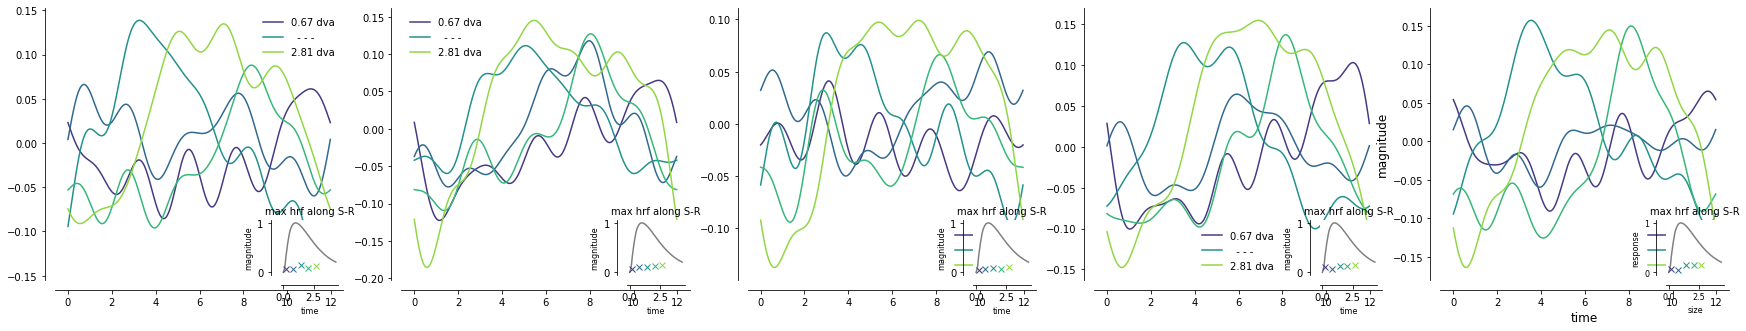

In [16]:
from mpl_toolkits.axes_grid.inset_locator import inset_axes

voxels = [358,363]
plot_vox = np.arange(voxels[0],voxels[1])

fig,axs = plt.subplots(1,len(plot_vox), figsize=(30,5))

for ax_id, vox in enumerate(plot_vox):

    max_vals = []
    for idc,ii in enumerate(cond):

        jj = tmp[(tmp['event type'] == str(ii))][f"vox {vox}"].values
        xx = tmp[(tmp['event type'] == str(ii))]['time'].values

        axs[ax_id].plot(xx,jj, color=cols[idc], label=f"{str(ii)} dva")
        sns.despine(offset=10)
        max_vals.append(np.amax(jj))
        
    max_vals = np.array(max_vals)
        
    plt.xlabel('time')
    plt.ylabel('magnitude')

    tmp_ax = axs[ax_id]
    for item in ([tmp_ax.xaxis.label, tmp_ax.yaxis.label] +
                tmp_ax.get_xticklabels() + tmp_ax.get_yticklabels()):
        item.set_fontsize(12)

    handles, labels = tmp_ax.get_legend_handles_labels()
    middle = int(round(float(len(handles) / 2),0))
    labels_new = [labels[0], '  - - -', labels[-1]]
    handles_new = [handles[0], handles[middle], handles[-1]]
    axs[ax_id].legend(handles_new, labels_new, frameon=False)
    # axs[ax_id].title('HRFs of different stimulus sizes').set_fontsize(14)
    left, bottom, width, height = [0.65, 0.45, 0.2, 0.2]
    ax2 = inset_axes(axs[ax_id], height="20%", width="20%", loc=4)
    sns.despine(offset=10)
    ax2.set_xlabel('size')
    ax2.set_ylabel('response')
    ax2.plot(stims_fill_sizes, mean_srf_fill, color=(128/255, 128/255, 128/255))

    for ix,kk in enumerate(max_vals):
        ax2.plot(dva_conds.astype(float)[ix], kk, color=cols[ix], marker='x')

    for item in ([ax2.xaxis.label, ax2.yaxis.label] +
                ax2.get_xticklabels() + ax2.get_yticklabels()):
        item.set_fontsize(8)
        
    ax2.set_title('max hrf along S-R')
    ax2.title.set_fontsize(10)
        
plt.show()

---
# Try pRF fit on line-data

In [17]:
func_file = "/data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-LR_run-3_bold.mat"
exp_file = "/data1/projects/MicroFunc/Jurjen/programs/linescanning/linescanning/experiments/sizeresponse/logs/sub-003_run-1_task-LR/sub-003_run-3_task-LR_events.tsv"

In [129]:
func = utils.ParseFuncFile(func_file, subject=1, run=1, deleted_first_timepoints=200, deleted_last_timepoints=100)
raw = func.get_raw(index=True)
psc = func.get_psc(index=True)
raw.head()

vox 0     vox 1     vox 2     vox 3     vox 4     vox 5  \
subject run t                                                                   
1       1   0.000  0.201584  0.134789  0.131508  0.256304  0.394299  0.132285   
            0.105  0.289404  0.141996  0.274313  0.479226  0.127432  0.359076   
            0.210  0.313689  0.044954  0.235828  0.465677  0.244281  0.020854   
            0.315  0.234696  0.085487  0.171515  0.172641  0.252372  0.299683   
            0.420  0.157801  0.102578  0.284273  0.464686  0.142938  0.075165   

                      vox 6     vox 7     vox 8     vox 9  ...   vox 710  \
subject run t                                              ...             
1       1   0.000  0.267819  0.293580  0.193254  0.044825  ...  0.225651   
            0.105  0.431722  0.332864  0.165787  0.284601  ...  0.200440   
            0.210  0.144831  0.280570  0.137389  0.137432  ...  0.097675   
            0.315  0.448892  0.184553  0.141692  0.312674  ...  0.200053   
            0.420  0.215536  0.090611  0.254900  0.187514  ...  0.226370   

                    vox 711   vox 712   vox 713   vox 714   vox 715   vox 716  \
subject run t                                                                   
1       1   0.000  0.191457  0.032873  0.065246  0.176070  0.120293  0.122677   
            0.105  0.142266  0.250650  0.056798  0.138566  0.146815  0.168327   
            0.210  0.114830  0.096092  0.099462  0.170589  0.060644  0.114042   
            0.315  0.041954  0.260525  0.103431  0.357175  0.164231  0.115956   
            0.420  0.203202  0.130427  0.258374  0.148143  0.244802  0.266076   

                    vox 717   vox 718   vox 719  
subject run t                                    
1       1   0.000  0.306302  0.321656  0.318697  
            0.105  0.295043  0.142685  0.156082  
            0.210  0.247919  0.084801  0.291756  
            0.315  0.246174  0.115957  0.068765  
            0.420  0.177328  0.182875  0.256534  

[5 rows x 720 columns]

In [132]:
# func_standard   = "/data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-standard_run-3.mat"
# func_nordic     = "/data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-nordic_run-3.mat"


# standard = utils.ParseFuncFile(func_standard, subject=1, run=1, deleted_first_timepoints=100, deleted_last_timepoints=100)
# nordic = utils.ParseFuncFile(func_nordic, subject=1, run=1, deleted_first_timepoints=100, deleted_last_timepoints=100)

# standard_raw = standard.get_raw(index=True)
# nordic_raw = nordic.get_raw(index=True)

# fig,axs = plt.subplots(1,2,figsize=(24,9))
# axs[0].imshow(standard_raw.T)
# axs[0].set_title('standard')
# axs[1].imshow(nordic_raw.T)
# axs[1].set_title('nordic')
# plt.show()

---
# Bad design below..

In [133]:
# psc.shape

In [134]:
# log_dir = opj(os.path.dirname(func_file))
# screensize = [1920,1080]

# dm = prf.create_line_prf_matrix(log_dir, run=3, n_samples=psc.shape[0], n_pix=screensize[-1]//4, delete_vols=38, stim_duration=0.315)
# dm.shape

In [135]:
# start = 40
# num = 20
# f, ss = plt.subplots(1,num,figsize=(24,3))
# for x in range(start,start+num):
#     ss[x-start].imshow(dm[...,x])
#     ss[x-start].axis('off')

In [136]:
# fig,axs = plt.subplots(1,2)
# axs[0].imshow(dm[...,189])
# axs[1].imshow(dm[...,189+107])

In [137]:
# # create stimulus
# vf_extent = [-5, 5]
# prf_stim = stimulus.PRFStimulus2D(screen_size_cm=70, screen_distance_cm=225, design_matrix=dm,TR=0.105)

# prf_array = prf.make_prf(prf_stim, size=params[2], mu_x=params[0], mu_y=params[1])
# prf.plot_prf(prf_array, vf_extent)

# # create grid
# grid_nr = 20
# max_ecc_size = 15
# sizes, eccs, polars = max_ecc_size * np.linspace(0.125,1,grid_nr)**2, \
#                     max_ecc_size * np.linspace(0.05,1,grid_nr)**2, \
#                         np.linspace(0, 2*np.pi, grid_nr, endpoint=False)

# gg_line = Iso2DGaussianModel(stimulus=prf_stim,
#                              filter_predictions=False,
#                              filter_type='sg',
#                              filter_params={'window_length':300, 
#                                             'polyorder':1})

# gg_line.create_grid_predictions(ecc_grid=eccs,
#                                 polar_grid=polars,
#                                 size_grid=sizes)

In [138]:
# print(f"Predictions have shape: {gg_line.predictions.shape}")
# print(f"Data has shape: {psc.values.shape}")

In [139]:
# # fit
# gf_line = Iso2DGaussianFitter(data=psc.values.T, model=gg_line, fit_css=False)

# gf_line.grid_fit(ecc_grid=eccs,
#                  polar_grid=polars,
#                  size_grid=sizes, 
#                  pos_prfs_only=False)

In [140]:
# vox = 359
# params_line = gf_line.gridsearch_params[vox,:]
# print(f"fit for vox {vox} = {params_line[-1]}")
# print(f"wb:   {[round(ii,2) for ii in params]}")
# print(f"line: {[round(ii,2) for ii in params_line]}")
# data = gf_line.data[vox,:]
# pred = gg_line.return_prediction(*params_line[:-1])[0]
# glm.plot_array([data,pred])

In [141]:
# prf_array2 = prf.make_prf(prf_stim, size=params_line[2], mu_x=params_line[0], mu_y=params_line[1])
# prf.plot_prf(prf_array2, vf_extent)

---
# Create good design..

In [311]:
# Load data
func = utils.ParseFuncFile(func_file, subject=1, run=1, deleted_first_timepoints=200, deleted_last_timepoints=200)
raw = func.get_raw(index=True)
psc = func.get_psc(index=True)
psc.head()

vox 0      vox 1     vox 2     vox 3      vox 4  \
subject run t                                                           
1       1   0.000 -3.804290 -13.977671 -6.116861  4.897714  23.537849   
            0.105 -5.013812 -14.023411 -5.862749  2.710724  18.738234   
            0.210 -5.261731 -15.235228 -2.598977 -0.250036  14.253700   
            0.315 -4.572934 -14.253306  1.172602  1.214230  10.728348   
            0.420 -5.372066 -15.922319  0.225461  0.054443   6.081879   

                       vox 5     vox 6      vox 7      vox 8      vox 9  ...  \
subject run t                                                            ...   
1       1   0.000 -11.532354 -0.811666  12.915743 -10.682922 -15.091252  ...   
            0.105 -13.662016 -0.604588   9.925008 -11.268652 -11.611134  ...   
            0.210 -14.136082  0.739837   8.535158 -12.516748  -7.847935  ...   
            0.315 -11.208707  3.876126   7.689679 -13.753855  -2.701014  ...   
            0.420 -10.680079  3.106606   7.050776 -13.338423  -0.194377  ...   

                    vox 710   vox 711    vox 712    vox 713   vox 714  \
subject run t                                                           
1       1   0.000  7.628798 -2.278656 -18.331497 -14.537787  3.962851   
            0.105  8.806276 -2.377385 -16.296011 -11.887783  4.023457   
            0.210  8.675694 -2.060944 -15.449267  -9.482468  4.822588   
            0.315  8.887005 -1.372236 -12.759781  -9.212756  5.793118   
            0.420  7.917631 -3.565586 -10.270744  -6.668180  4.731548   

                    vox 715   vox 716    vox 717    vox 718    vox 719  
subject run t                                                           
1       1   0.000 -7.626307 -4.035836  19.010294  12.470114  19.467926  
            0.105 -7.655263 -5.107957  16.796267  10.775864  15.730274  
            0.210 -5.774254 -5.323875  18.056320   9.734762  16.133129  
            0.315 -4.174078 -4.631507  15.552986   7.217848  16.149866  
            0.420 -5.030232 -3.803611  15.586352   6.448996  12.247396  

[5 rows x 720 columns]

In [312]:
# Load data
bp_filter = "boxcar"

func_file = "/data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-3_badeyetrack/func/sub-003_ses-3_task-LR_run-3_bold.mat"

func = utils.ParseFuncFile(func_file, bp_filter="boxcar", window_size=15, subject=1, run=1, deleted_first_timepoints=200, deleted_last_timepoints=200)
func1 = utils.ParseFuncFile(func_file, bp_filter="rolling", window_size=20, subject=1, run=1, deleted_first_timepoints=200, deleted_last_timepoints=200)

raw = func.get_raw(index=True)
psc = func.get_psc(index=True)
rolling = func1.get_rolling()
psc.head()

vox 0      vox 1     vox 2     vox 3      vox 4  \
subject run t                                                           
1       1   0.000 -3.804290 -13.977671 -6.116861  4.897714  23.537849   
            0.105 -5.013812 -14.023411 -5.862749  2.710724  18.738234   
            0.210 -5.261731 -15.235228 -2.598977 -0.250036  14.253700   
            0.315 -4.572934 -14.253306  1.172602  1.214230  10.728348   
            0.420 -5.372066 -15.922319  0.225461  0.054443   6.081879   

                       vox 5     vox 6      vox 7      vox 8      vox 9  ...  \
subject run t                                                            ...   
1       1   0.000 -11.532354 -0.811666  12.915743 -10.682922 -15.091252  ...   
            0.105 -13.662016 -0.604588   9.925008 -11.268652 -11.611134  ...   
            0.210 -14.136082  0.739837   8.535158 -12.516748  -7.847935  ...   
            0.315 -11.208707  3.876126   7.689679 -13.753855  -2.701014  ...   
            0.420 -10.680079  3.106606   7.050776 -13.338423  -0.194377  ...   

                    vox 710   vox 711    vox 712    vox 713   vox 714  \
subject run t                                                           
1       1   0.000  7.628798 -2.278656 -18.331497 -14.537787  3.962851   
            0.105  8.806276 -2.377385 -16.296011 -11.887783  4.023457   
            0.210  8.675694 -2.060944 -15.449267  -9.482468  4.822588   
            0.315  8.887005 -1.372236 -12.759781  -9.212756  5.793118   
            0.420  7.917631 -3.565586 -10.270744  -6.668180  4.731548   

                    vox 715   vox 716    vox 717    vox 718    vox 719  
subject run t                                                           
1       1   0.000 -7.626307 -4.035836  19.010294  12.470114  19.467926  
            0.105 -7.655263 -5.107957  16.796267  10.775864  15.730274  
            0.210 -5.774254 -5.323875  18.056320   9.734762  16.133129  
            0.315 -4.174078 -4.631507  15.552986   7.217848  16.149866  
            0.420 -5.030232 -3.803611  15.586352   6.448996  12.247396  

[5 rows x 720 columns]

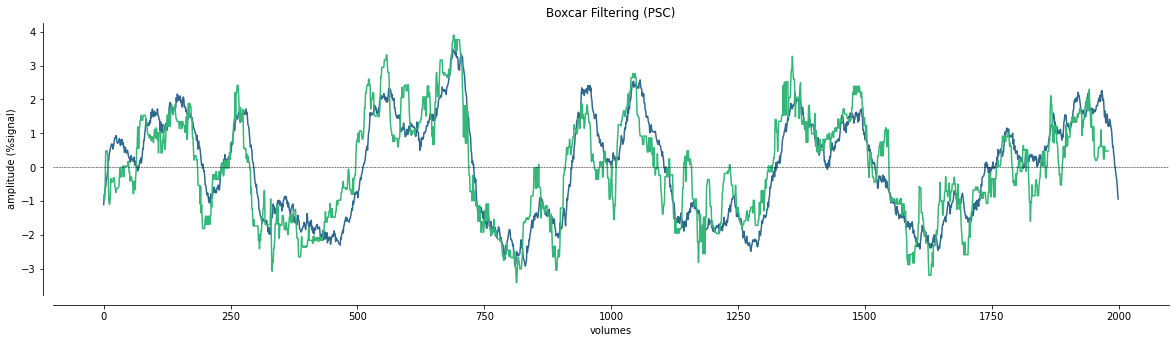

Data has shape (2000, 720)


In [313]:
plot_vox = 359
glm.plot_array([psc[f"vox {plot_vox}"].values, rolling[f"vox {plot_vox}"].values[func1.window_size:,...]],
               figsize=(20,5),
               x_label="volumes",
               y_label="amplitude (%signal)",
               title=f"Boxcar Filtering (PSC)",
               add_hline={'pos': 0, 'color': 'k', 'lw': 0.5, 'ls': '--'})

print(f"Data has shape {psc.shape}")

In [191]:
%reload_ext autoreload
%autoreload 2

In [193]:
n_pix = 270
design_matrix_line = prf.create_line_prf_matrix(log_dir, 
                                                stim_duration=0.315, 
                                                n_pix=n_pix, 
                                                deleted_first_timepoints=func.deleted_first_timepoints,
                                                deleted_last_timepoints=0,
                                                TR=func.TR)

design_matrix_line.shape                                        

Baseline before has shape: (270, 270, 28)
Design itself has shape: (270, 270, 1500)
Baseline after has shape: (270, 270, 228)


(270, 270, 1756)

(270, 270, 1756)


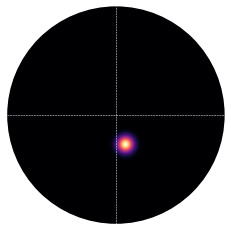

In [315]:
# create stimulus
bp_filter = "boxcar"

vf_extent = [-5, 5]

if bp_filter == "rolling":
    dm = design_matrix_line[...,func1.window_size:]
else:
    dm = design_matrix_line
    
distance = 225+10 # compensate for not putting BOLD screen back
prf_stim = stimulus.PRFStimulus2D(screen_size_cm=70, 
                                  screen_distance_cm=distance, 
                                  design_matrix=dm,
                                  TR=func.TR)

prf_array = prf.make_prf(prf_stim, size=params[2], mu_x=params[0], mu_y=params[1])
prf.plot_prf(prf_array, vf_extent)

# create grid
grid_nr = 20
max_ecc_size = 15
sizes, eccs, polars = max_ecc_size * np.linspace(0.125,1,grid_nr)**2, \
                    max_ecc_size * np.linspace(0.05,1,grid_nr)**2, \
                        np.linspace(0, 2*np.pi, grid_nr, endpoint=False)

gg_line = Iso2DGaussianModel(stimulus=prf_stim,
                             filter_predictions=False,
                             filter_type='sg',
                             filter_params={'window_length':300, 
                                            'polyorder':1})

print(dm.shape)

In [319]:
if bp_filter == "rolling":
    data = rolling.values[func1.window_size:func1.window_size+dm.shape[-1],359].T
else:
    data = psc[f'vox {plot_vox}'].values[...,:dm.shape[-1]]

if data.ndim == 1:
    data = data[np.newaxis,...]
print(f"Data has shape: {data.shape}")

Data has shape: (1, 1756)


In [292]:
# fit
gf_line = Iso2DGaussianFitter(data=data, model=gg_line, fit_css=False)

gf_line.grid_fit(ecc_grid=eccs,
                 polar_grid=polars,
                 size_grid=sizes, 
                 pos_prfs_only=False)

fit for vox 359 = 0.6907305717468262
wb:   [0.74, -2.28, 0.44, 0.0, -0.22, 0.74]
line: [2.46, -1.79, 1.89, 0.0, -1.2, 0.69]


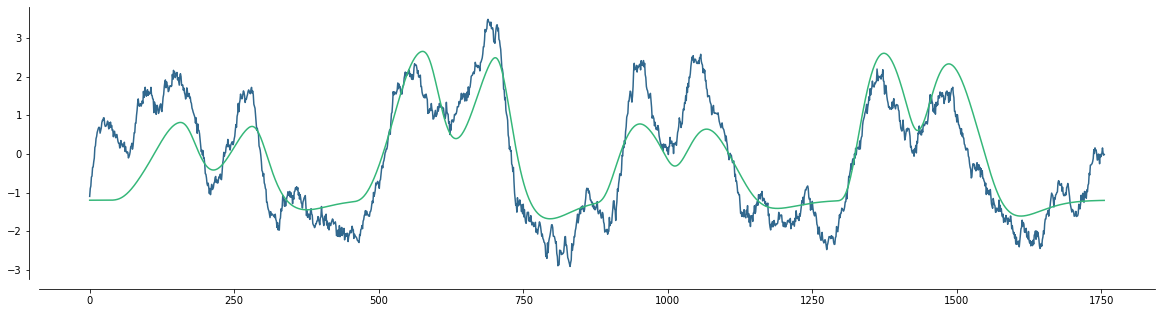

In [310]:
vox = 359
params_line = gf_line.gridsearch_params[0]
print(f"fit for vox {vox} = {params_line[-1]}")
print(f"wb:   {[round(ii,2) for ii in params]}")
print(f"line: {[round(ii,2) for ii in params_line]}")
data = gf_line.data[0]
pred = gg_line.return_prediction(*params_line[:-1])[0]
glm.plot_array([data, pred], figsize=(20,5))

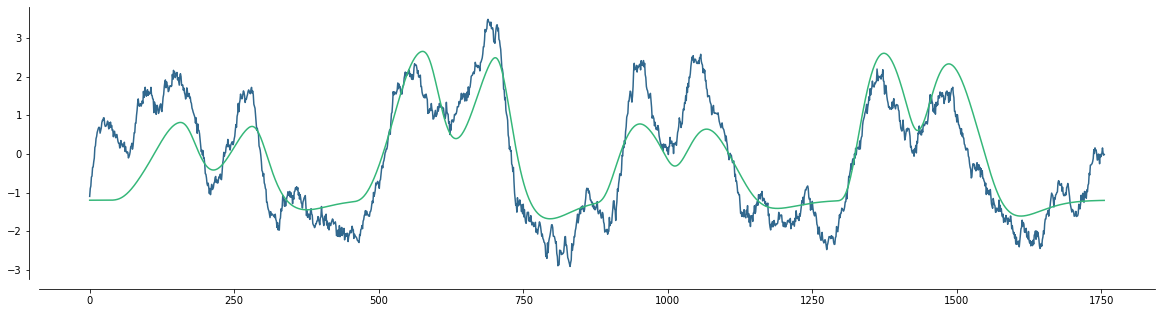

In [323]:
glm.plot_array([psc['vox 359'].values[:dm.shape[-1],...],pred], figsize=(20,5))

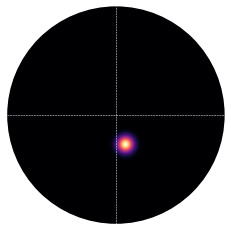

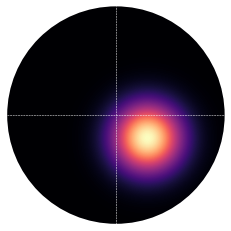

In [277]:
prf_wb = prf.make_prf(prf_stim, size=params[2], mu_x=params[0], mu_y=params[1])
prf_wb_ax = prf.plot_prf(prf_wb, vf_extent, return_axis=True) #, save_as=opj(fig_dir, 'sub-003_wb_prf.svg'))

prf_line = prf.make_prf(prf_stim, size=params_line[2], mu_x=params_line[0], mu_y=params_line[1])
prf_line_ax = prf.plot_prf(prf_line, vf_extent, return_axis=True) #, save_as=opj(fig_dir, 'sub-003_line_prf.svg'))

In [279]:
prf.distance_centers(params, params_line)

1.7863198123553536

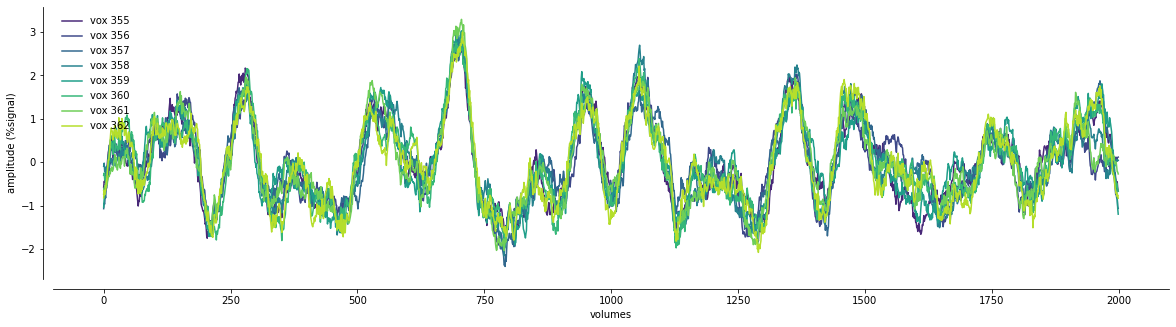

In [201]:
fig,axs = plt.subplots(figsize=(20,5))
ribbon = [355,363]
depth = np.arange(*ribbon)
colors = sns.color_palette('viridis', len(depth))

for ix, i in enumerate(range(*ribbon)):
    axs.plot(psc.values[:,i], color=colors[ix], label=f"vox {i}")

axs.set_xlabel("volumes")
axs.set_ylabel("amplitude (%signal)")
axs.legend(frameon=False)
sns.despine(offset=10)

In [202]:
gg_line_norm = Norm_Iso2DGaussianModel(stimulus=prf_stim,
                                  filter_predictions=False,
                                  filter_type='sg',
                                  filter_params={'window_length':300,'polyorder':1})

# only run iterative fit on ribbon voxels
data = psc.values[:gg_line.predictions.shape[-1],ribbon[0]:ribbon[1]].T

# initiate fitter
gf_line_norm = Norm_Iso2DGaussianFitter(gg_line_norm, data)

# Run iterative fit with Normalization model; make n_units x 4 array, with X,Y,size,r2
old_params_arr = gf_line.gridsearch_params
old_params = np.hstack((old_params_arr[ribbon[0]:ribbon[1],:3], old_params_arr[ribbon[0]:ribbon[1],-1][...,np.newaxis]))
print(old_params_filt)

[[ 1.785 -2.457  0.707  0.552]
 [ 2.457 -1.785  1.039  0.519]
 [ 1.942 -1.411  1.039  0.599]
 [ 2.457 -1.785  0.707  0.577]
 [ 1.785 -2.457  0.707  0.61 ]
 [ 3.037  0.     1.434  0.492]
 [ 1.785 -2.457  0.707  0.531]
 [ 3.037  0.     1.434  0.544]]


In [204]:
# define parameters
surround_amplitude_grid=np.array([0.01,0.1,1,10], dtype='float32')
surround_size_grid=np.array([5,8,12,18], dtype='float32')
neural_baseline_grid=np.array([0,1,10,100], dtype='float32')
surround_baseline_grid=np.array([0.1,1.0,10.0,100.0], dtype='float32')

# run gridfit
gf_line_norm.grid_fit(surround_amplitude_grid, surround_size_grid, neural_baseline_grid,surround_baseline_grid, gaussian_params=old_params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   11.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   17.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   20.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   23.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   23.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   23.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   23.9s finished


In [205]:
# iterative fit
eps = 1e-1
ss = prf_stim.screen_size_degrees
xtol = 0.00001
ftol = 0.00001
constraints_norm = []
rsq_threshold = 0.1

norm_bounds = [(-1.5*max_ecc_size, 1.5*max_ecc_size),   # x
                (-1.5*max_ecc_size, 1.5*max_ecc_size),  # y
                (eps, 1.5*ss),                          # prf size
                (0, 1000),                              # prf amplitude       = A term
                (0, 1000),                              # bold baseline
                (0, 1000),                              # surround amplitude  = C term
                (eps, 3*ss),                            # surround size
                (0, 1000),                              # neural baseline     = B term
                (1e-6, 1000)]                           # surround baseline   = D term

gf_line_norm.iterative_fit(rsq_threshold=rsq_threshold, 
                      verbose=True,
                      bounds=norm_bounds,
                      constraints=constraints_norm,
                      xtol=xtol,
                      ftol=ftol)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Performing bounded, constrained minimization (trust-constr).
The maximum number of function evaluations is exceeded.
Number of iterations: 1000, function evaluations: 10250, CG iterations: 5134, optimality: 8.35e-03, constraint violation: 0.00e+00, execution time: 8.2e+02 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 543, function evaluations: 5970, CG iterations: 3628, optimality: 5.03e-03, constraint violation: 0.00e+00, execution time: 4.8e+02 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 366, function evaluations: 3920, CG iterations: 2020, optimality: 1.94e-05, constraint violation: 0.00e+00, execution time: 3.2e+02 s.
Performing bounded, constrained minimization (trust-constr).
The maximum number of function evaluations is exceeded.
Number of iterations: 1000, function evaluations: 10520, CG iterations: 3549, optimal

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 77.6min finished


In [206]:
iter_params = gf_line_norm.iterative_search_params
print(iter_params)

[[  1.94   -2.527   0.677  32.026   0.      7.688   0.855   0.005   0.003
    0.477]
 [  2.107  -2.12    0.259   9.363   0.      0.532   0.986   0.      0.
    0.388]
 [  1.951  -0.129   0.187  12.242   0.      0.197   1.152   0.     99.943
    0.366]
 [  2.09   -2.145   0.325 317.911   0.     31.033   0.75    0.      0.
    0.488]
 [  1.879  -2.471   0.487  54.516   0.     11.797   0.731   0.      0.001
    0.44 ]
 [  2.2    -0.066   0.1    13.802   0.      0.019  50.768   0.3    23.035
    0.362]
 [  2.029  -2.512   0.644  17.373   0.      4.588   0.849   0.003   0.003
    0.427]
 [  2.23   -0.132   0.1     2.126   0.      0.003   2.871   0.      7.07
    0.352]]


[ 1.94  -2.527  0.677 32.026  0.     7.688  0.855  0.005  0.003  0.477]


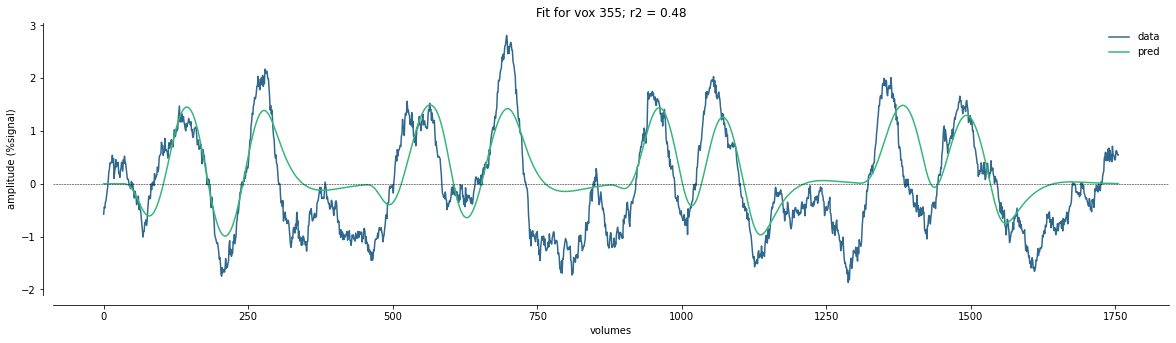

[ 2.107 -2.12   0.259  9.363  0.     0.532  0.986  0.     0.     0.388]


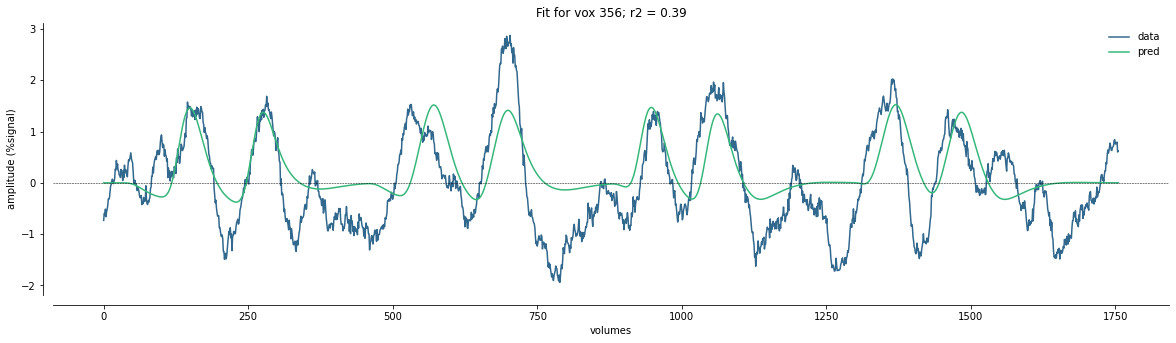

[ 1.951 -0.129  0.187 12.242  0.     0.197  1.152  0.    99.943  0.366]


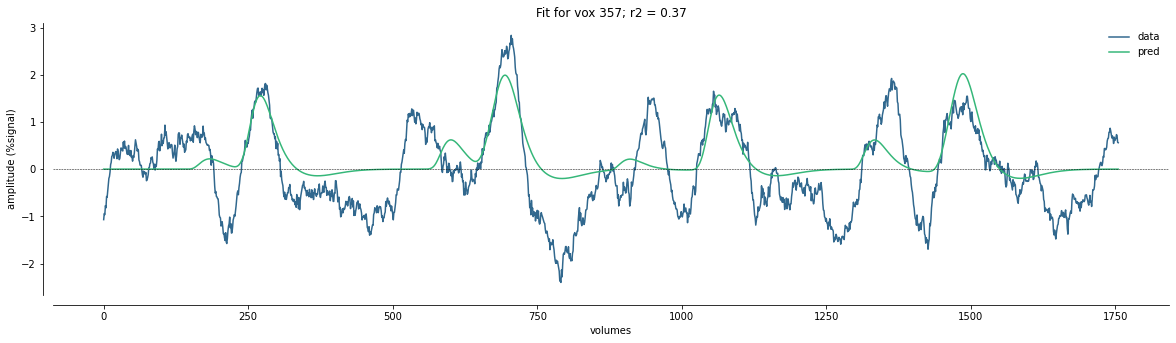

[  2.09   -2.145   0.325 317.911   0.     31.033   0.75    0.      0.
   0.488]


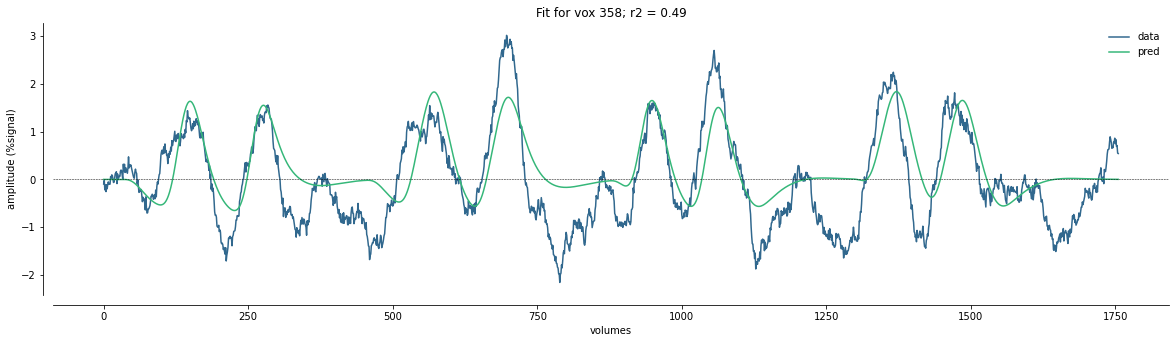

[ 1.879 -2.471  0.487 54.516  0.    11.797  0.731  0.     0.001  0.44 ]


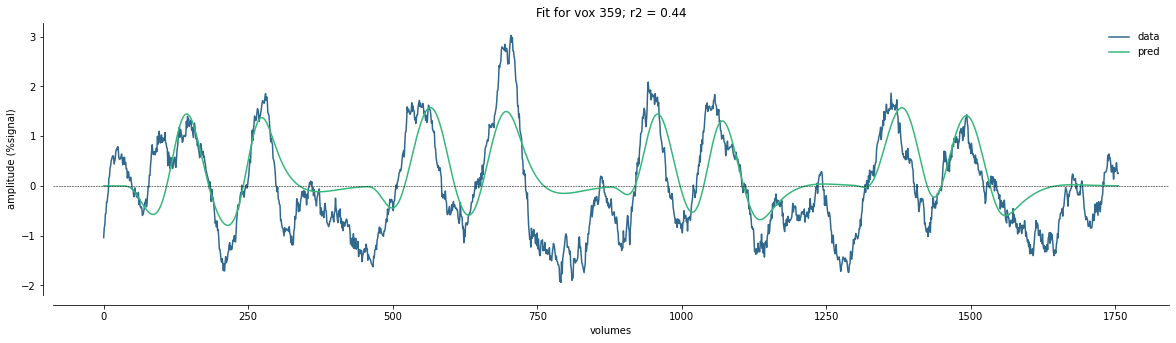

[ 2.2   -0.066  0.1   13.802  0.     0.019 50.768  0.3   23.035  0.362]


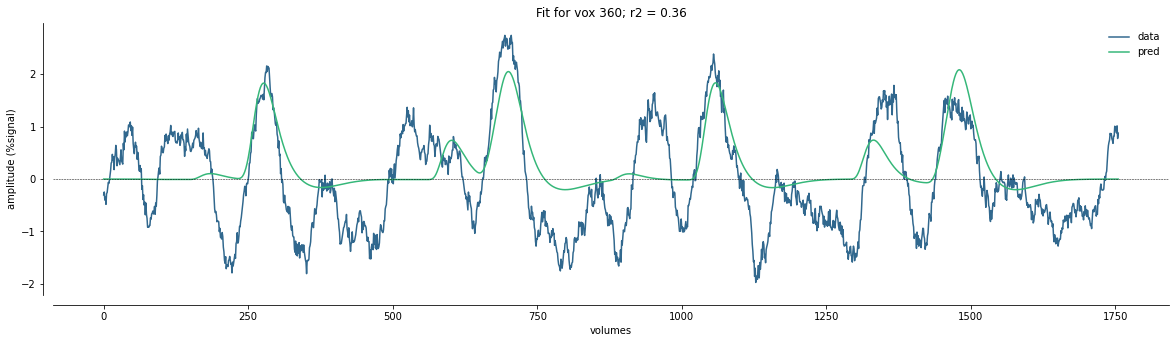

[ 2.029 -2.512  0.644 17.373  0.     4.588  0.849  0.003  0.003  0.427]


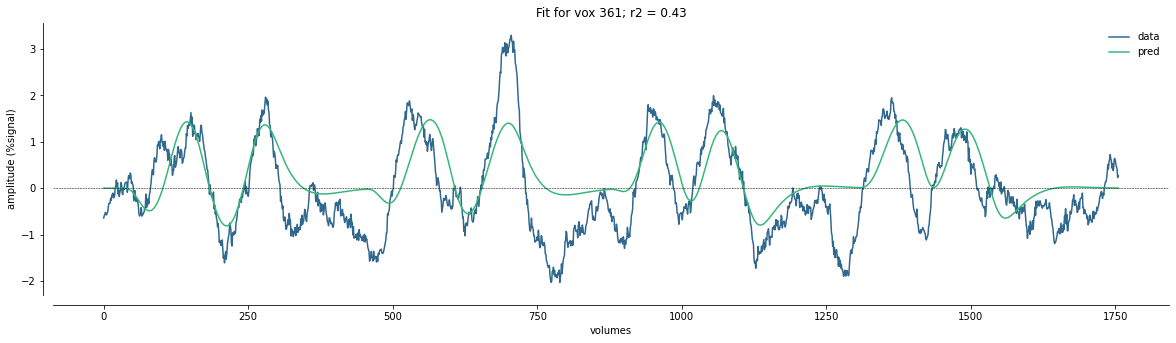

[ 2.23  -0.132  0.1    2.126  0.     0.003  2.871  0.     7.07   0.352]


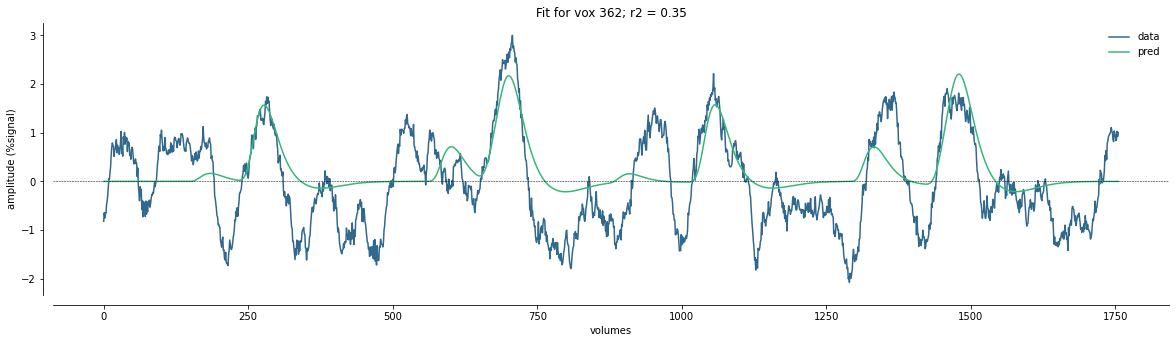

In [211]:
for ix, ii in enumerate(range(*ribbon)):
    
    pars = gf_line_norm.iterative_search_params[ix]
    print(pars)
    data = gf_line_norm.data[ix,:]
    pred = np.squeeze(gg_line_norm.return_prediction(*pars[:-1]),0)
    glm.plot_array([data,pred], 
                labels=["data", "pred"], 
                x_label="volumes", 
                y_label="amplitude (%signal)",
                title=f"Fit for vox {ii}; r2 = {round(pars[-1],2)}",
                figsize=(20,5),
                add_hline={'pos': 0 , 'color': 'k', 'lw': 0.5, 'ls': '--'})

(8, 10)


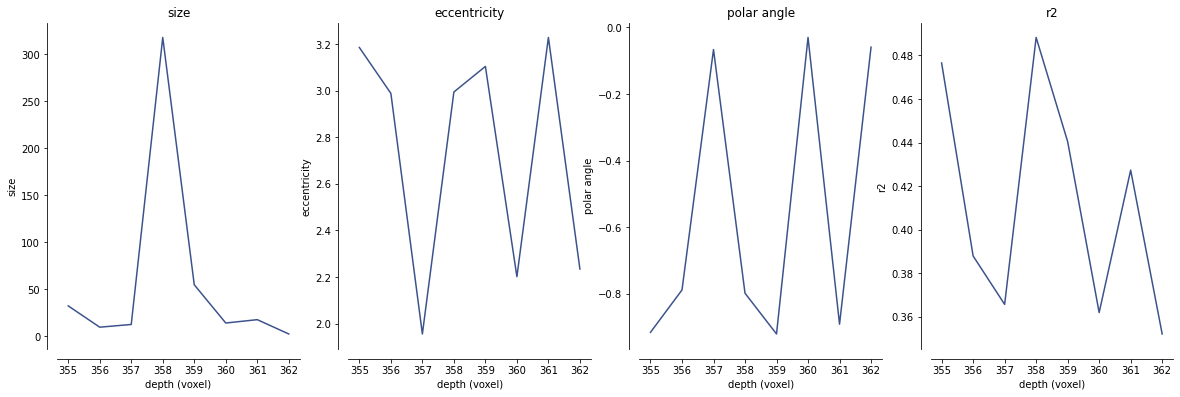

In [210]:
prf_pars = gf_line_norm.iterative_search_params
print(prf_pars.shape)

# calculate eccentricity & polar angle
r2 = prf_pars[...,-1]
ecc = np.sqrt(prf_pars[...,0]**2+prf_pars[...,1]**2)
polar = np.angle(prf_pars[...,0]+prf_pars[...,1]*1j)
size = prf_pars[...,3]

# plot
fig,axs = plt.subplots(1,4, figsize=(20,6))
depth = np.arange(*ribbon)
colors = sns.color_palette('viridis', 3)

axs[0].plot(depth, size, color=colors[0])
axs[0].set_title("size")
axs[0].set_xlabel("depth (voxel)")
axs[0].set_ylabel("size")

axs[1].plot(depth, ecc, color=colors[0])
axs[1].set_title("eccentricity")
axs[1].set_xlabel("depth (voxel)")
axs[1].set_ylabel("eccentricity")

axs[2].plot(depth, polar, color=colors[0])
axs[2].set_title("polar angle")
axs[2].set_xlabel("depth (voxel)")
axs[2].set_ylabel("polar angle")

axs[3].plot(depth, r2, color=colors[0])
axs[3].set_title("r2")
axs[3].set_xlabel("depth (voxel)")
axs[3].set_ylabel("r2")

sns.despine(offset=10)

[ 6.   6.5  7.   7.5  8.   8.5  9.   9.5 10.  10.5]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[ 3  4  5  6  7  8  9 10 11 12]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


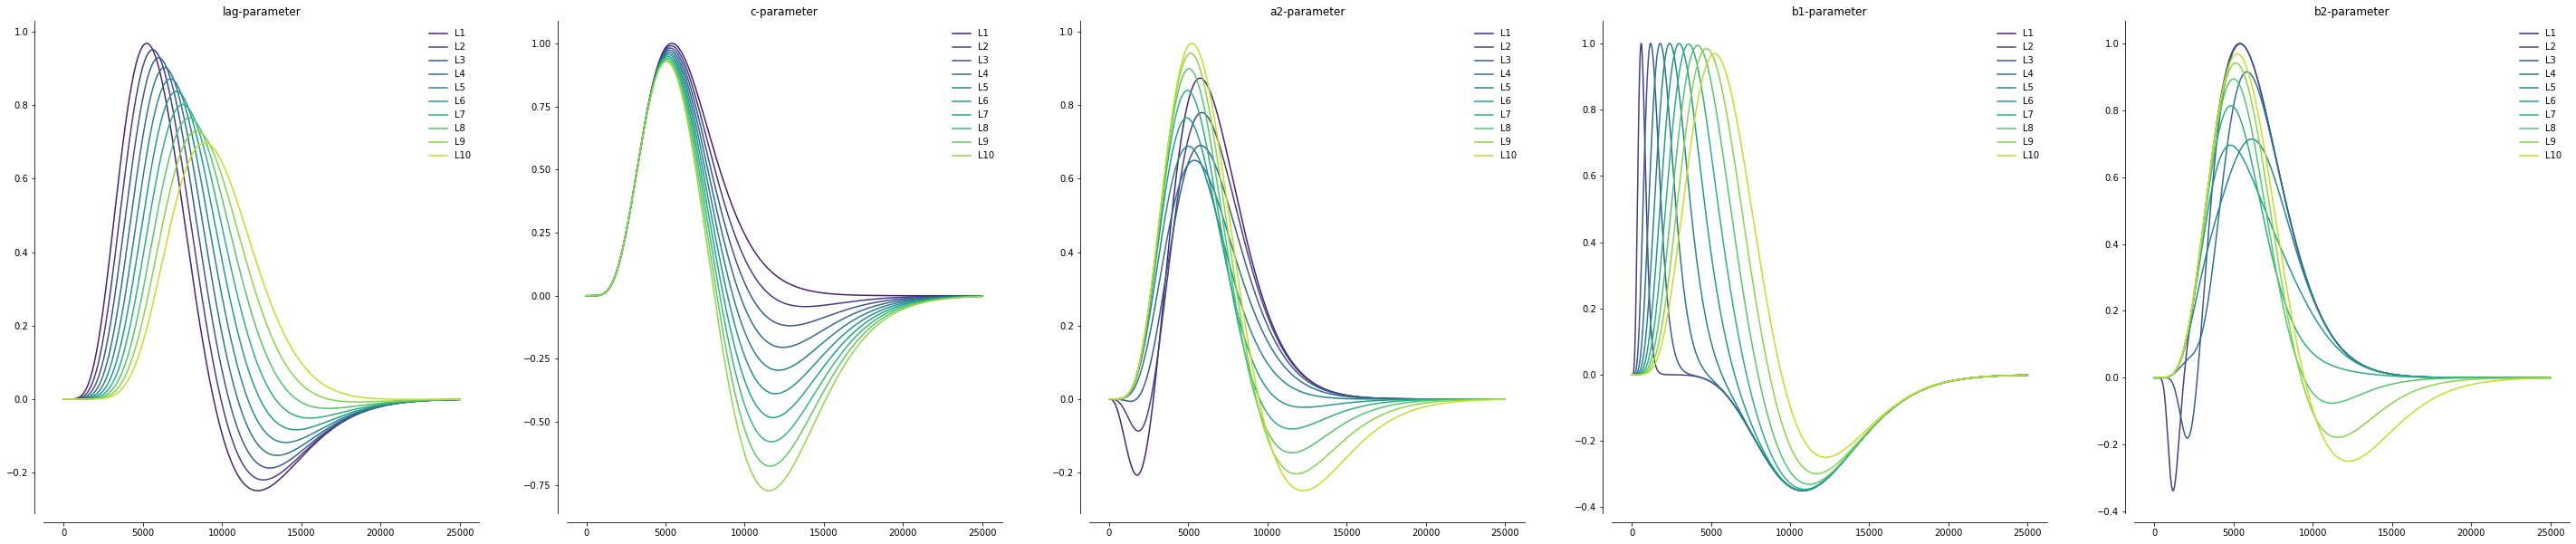

In [7]:
## Plot different HRF parameters

#---------------------------------------------------------------------------------------
# change the lag of HRF
hrf_lags = np.arange(6,11,0.5)
print(hrf_lags)
col_hrfs = sns.color_palette('viridis', hrf_lags.shape[0])

fig,axs = plt.subplots(1,5,figsize=(50,10))
# axs.plot(canonical_hrf, color=col_hrfs[0], label='canonical')
hrfs = []
for ix,ii in enumerate(hrf_lags):
    hrf = glm.double_gamma(time_points, lag=ii, scale=False)
    hrfs.append(hrf)
    axs[0].plot(hrf, color=col_hrfs[ix], label=f'L{ix+1}')
    axs[0].legend(frameon=False)
    sns.despine(offset=10)

    axs[0].set_title('lag-parameter')


#---------------------------------------------------------------------------------------
# change C-parameter of HRF
hrf_c = np.arange(0,1,0.1)
print(hrf_c)
col_hrfs = sns.color_palette('viridis', hrf_c.shape[0]+1)

# axs.plot(canonical_hrf, color=col_hrfs[0], label='canonical')
hrfs = []
for ix,ii in enumerate(hrf_c):
    hrf = glm.double_gamma(time_points, c=ii, scale=False)
    hrfs.append(hrf)
    axs[1].plot(hrf, color=col_hrfs[ix], label=f'L{ix+1}')
    axs[1].legend(frameon=False)
    sns.despine(offset=10)

    axs[1].set_title('c-parameter')


#---------------------------------------------------------------------------------------
# change a2-parameter of HRF
hrf_a2 = np.arange(3,13,1)
print(hrf_a2)
col_hrfs = sns.color_palette('viridis', hrf_a2.shape[0])

# axs.plot(canonical_hrf, color=col_hrfs[0], label='canonical')
hrfs = []
for ix,ii in enumerate(hrf_a2):
    hrf = glm.double_gamma(time_points, a2=ii, scale=False)
    hrfs.append(hrf)
    axs[2].plot(hrf, color=col_hrfs[ix], label=f'L{ix+1}')
    axs[2].legend(frameon=False)
    sns.despine(offset=10)

    axs[2].set_title('a2-parameter')


#---------------------------------------------------------------------------------------
# change b1-parameter of HRF
hrf_b1 = np.arange(0,1,0.1)
print(hrf_b1)
col_hrfs = sns.color_palette('viridis', hrf_b1.shape[0])

# axs.plot(canonical_hrf, color=col_hrfs[0], label='canonical')
hrfs = []
for ix,ii in enumerate(hrf_b1):
    hrf = glm.double_gamma(time_points, b1=ii, scale=False)
    hrfs.append(hrf)
    axs[3].plot(hrf, color=col_hrfs[ix], label=f'L{ix+1}')
    axs[3].legend(frameon=False)
    sns.despine(offset=10)

    axs[3].set_title('b1-parameter')


#---------------------------------------------------------------------------------------
# change b2-parameter of HRF
hrf_b2 = np.arange(0,1,0.1)
print(hrf_b2)
col_hrfs = sns.color_palette('viridis', hrf_b2.shape[0])

# axs.plot(canonical_hrf, color=col_hrfs[0], label='canonical')
hrfs = []
for ix,ii in enumerate(hrf_b2):
    hrf = glm.double_gamma(time_points, b2=ii, scale=False)
    hrfs.append(hrf)
    axs[4].plot(hrf, color=col_hrfs[ix], label=f'L{ix+1}')
    axs[4].legend(frameon=False)
    sns.despine(offset=10)

    axs[4].set_title('b2-parameter')      

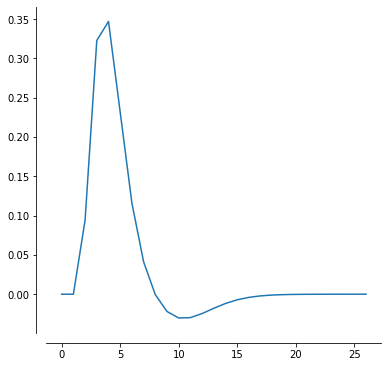

In [16]:
fig,axs = plt.subplots(figsize=(6,6))
axs.plot(gg.hrf[0])
# axs.plot(glm.double_gamma(np.arange(0,25), scale=True))
sns.despine(offset=10)